In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('Hypertension-risk-model-main.csv')

# Data Preprocessing
# Handle missing values
df.fillna(df.median(), inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Define features and target
X = df.drop('Risk', axis=1)
y = df['Risk']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Feature Selection and Dimensionality Reduction
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Sequential Feature Selection
sfs = SFS(LinearRegression(), n_features_to_select=10, direction='forward')
sfs.fit(X_train, y_train)
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

In [4]:
# Model Development
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5)
ridge_cv.fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5)
lasso_cv.fit(X_train, y_train)
y_pred_lasso = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)
kmeans_labels = kmeans.predict(X_test)

# Model Evaluation
# Collect results in a DataFrame
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'MSE': [lr_mse, ridge_mse, lasso_mse],
    'R^2': [lr_r2, ridge_r2, lasso_r2]
})

# Interpretation and Insights
feature_importances_lr = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
feature_importances_ridge = pd.Series(ridge_cv.best_estimator_.coef_, index=X.columns).sort_values(ascending=False)
feature_importances_lasso = pd.Series(lasso_cv.best_estimator_.coef_, index=X.columns).sort_values(ascending=False)

# Display results
print(results)

# Print the results
print("Model Performance Comparison:")
print(f"Linear Regression: MSE = {lr_mse:.4f}, R^2 = {lr_r2:.4f}")
print(f"Ridge Regression: MSE = {ridge_mse:.4f}, R^2 = {ridge_r2:.4f}")
print(f"Lasso Regression: MSE = {lasso_mse:.4f}, R^2 = {lasso_r2:.4f}")

               Model       MSE       R^2
0  Linear Regression  0.489975  0.498800
1   Ridge Regression  0.489973  0.498802
2   Lasso Regression  0.514904  0.473300
Model Performance Comparison:
Linear Regression: MSE = 0.4900, R^2 = 0.4988
Ridge Regression: MSE = 0.4900, R^2 = 0.4988
Lasso Regression: MSE = 0.5149, R^2 = 0.4733


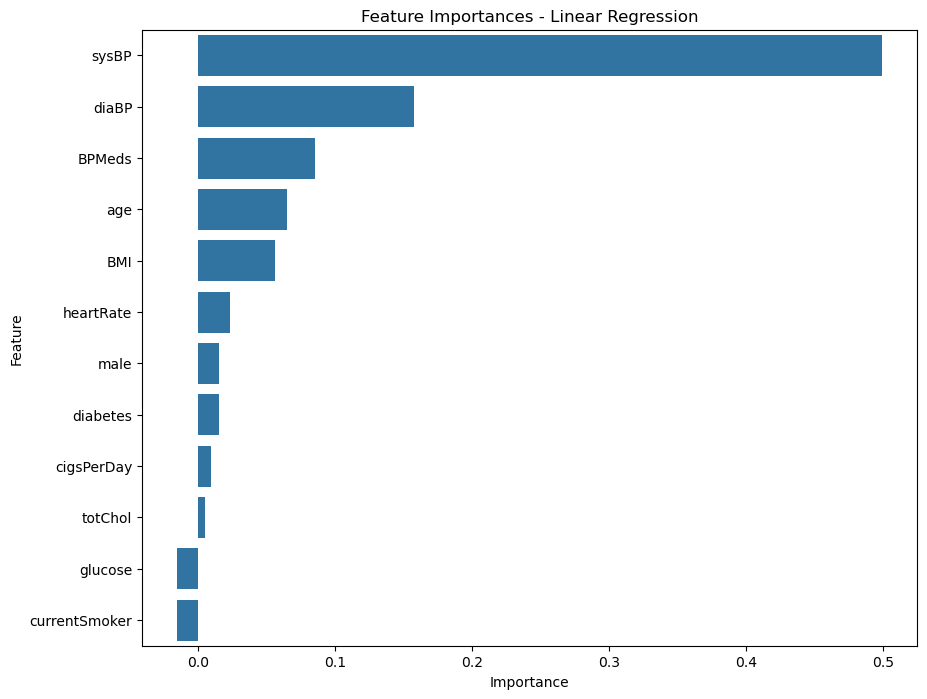

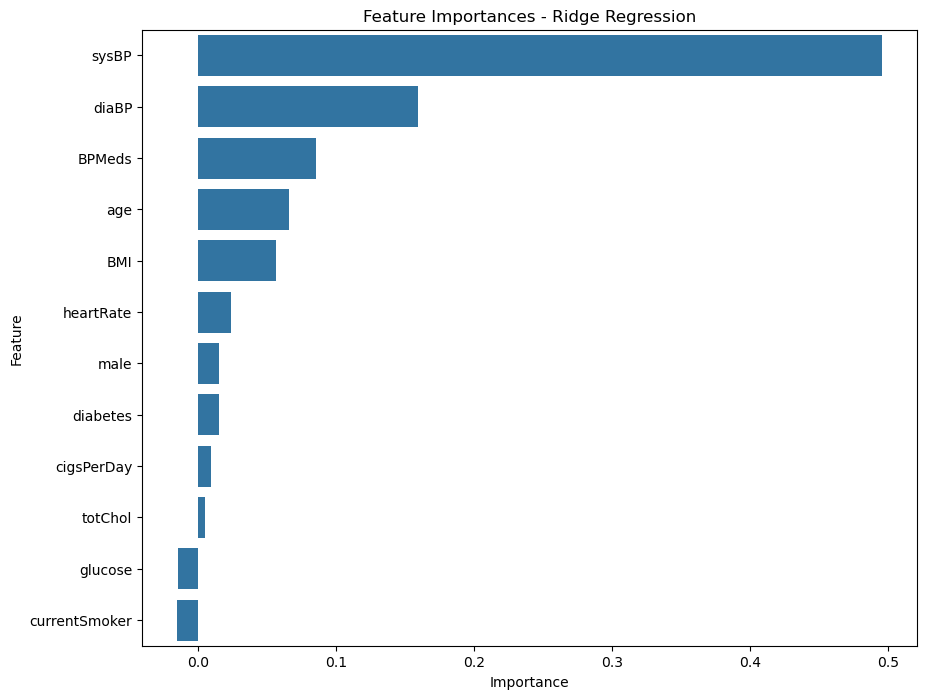

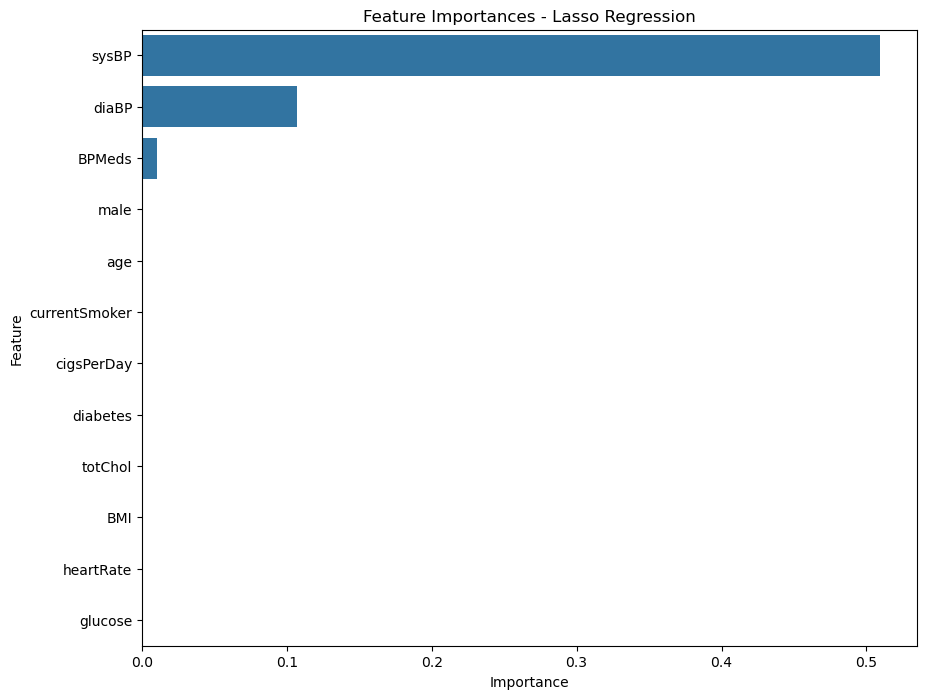

In [5]:
# Function to plot feature importances
def plot_feature_importances(importances, title):
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances.values, y=importances.index)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Plot feature importances for Linear Regression
plot_feature_importances(feature_importances_lr, 'Feature Importances - Linear Regression')
# Plot feature importances for Ridge Regression
plot_feature_importances(feature_importances_ridge, 'Feature Importances - Ridge Regression')
# Plot feature importances for Lasso Regression
plot_feature_importances(feature_importances_lasso, 'Feature Importances - Lasso Regression')

# Create interaction and polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Split data into training and testing sets with new features
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

                                  Model       MSE       R^2
0                     Linear Regression  0.489975  0.498800
1                      Ridge Regression  0.489973  0.498802
2                      Lasso Regression  0.514904  0.473300
3  Linear Regression with Poly Features  0.475583  0.513522
4   Ridge Regression with Poly Features  0.475056  0.514061
5   Lasso Regression with Poly Features  0.514904  0.473300


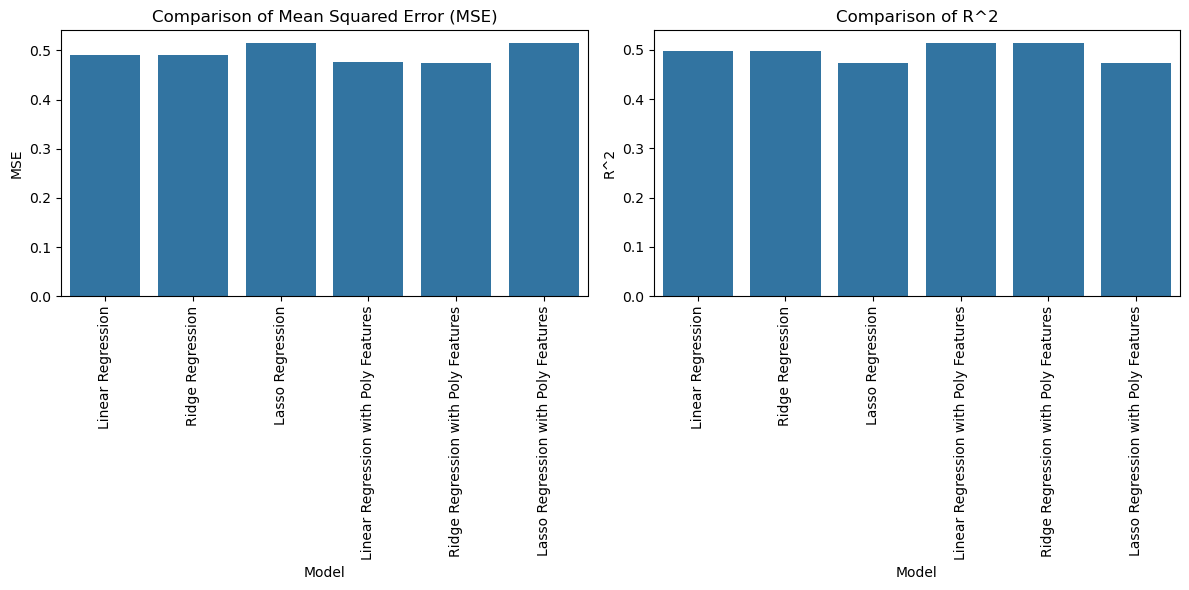

In [6]:
# Model Development with new features
# Linear Regression with new features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train_poly)
y_pred_lr_poly = lr_poly.predict(X_test_poly)
lr_poly_mse = mean_squared_error(y_test_poly, y_pred_lr_poly)
lr_poly_r2 = r2_score(y_test_poly, y_pred_lr_poly)

# Ridge Regression with new features
ridge_poly = Ridge()
ridge_poly_cv = GridSearchCV(ridge_poly, ridge_params, cv=5)
ridge_poly_cv.fit(X_train_poly, y_train_poly)
y_pred_ridge_poly = ridge_poly_cv.predict(X_test_poly)
ridge_poly_mse = mean_squared_error(y_test_poly, y_pred_ridge_poly)
ridge_poly_r2 = r2_score(y_test_poly, y_pred_ridge_poly)

# Lasso Regression with new features
lasso_poly = Lasso()
lasso_poly_cv = GridSearchCV(lasso_poly, lasso_params, cv=5)
lasso_poly_cv.fit(X_train_poly, y_train_poly)
y_pred_lasso_poly = lasso_poly_cv.predict(X_test_poly)
lasso_poly_mse = mean_squared_error(y_test_poly, y_pred_lasso_poly)
lasso_poly_r2 = r2_score(y_test_poly, y_pred_lasso_poly)

# Model Evaluation with new features
# Collect results in a DataFrame
results_poly = pd.DataFrame({
    'Model': ['Linear Regression with Poly Features', 'Ridge Regression with Poly Features', 'Lasso Regression with Poly Features'],
    'MSE': [lr_poly_mse, ridge_poly_mse, lasso_poly_mse],
    'R^2': [lr_poly_r2, ridge_poly_r2, lasso_poly_r2]
})

# Combine initial and new results
combined_results = pd.concat([results, results_poly], ignore_index=True)

# Display combined results
print(combined_results)

# Visualization of Results
# Plot comparison of MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MSE', data=combined_results)
plt.title('Comparison of Mean Squared Error (MSE)')
plt.xticks(rotation=90)

# Plot comparison of R^2
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R^2', data=combined_results)
plt.title('Comparison of R^2')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
# New Ensemble Methods

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train_poly, y_train_poly)
y_pred_rf = rf_grid.predict(X_test_poly)
rf_mse = mean_squared_error(y_test_poly, y_pred_rf)
rf_r2 = r2_score(y_test_poly, y_pred_rf)

# Voting Ensemble
voting_regressor = VotingRegressor([
    ('lr', lr_poly),
    ('ridge', ridge_poly_cv.best_estimator_),
    ('lasso', lasso_poly_cv.best_estimator_),
    ('rf', rf_grid.best_estimator_)
])

voting_regressor.fit(X_train_poly, y_train_poly)
y_pred_voting = voting_regressor.predict(X_test_poly)
voting_mse = mean_squared_error(y_test_poly, y_pred_voting)
voting_r2 = r2_score(y_test_poly, y_pred_voting)

# Add new results to the combined_results DataFrame
new_results = pd.DataFrame({
    'Model': ['Random Forest', 'Voting Ensemble'],
    'MSE': [rf_mse, voting_mse],
    'R^2': [rf_r2, voting_r2]
})

all_results = pd.concat([combined_results, new_results], ignore_index=True)

# Display all results
print(all_results)



                                  Model       MSE       R^2
0                     Linear Regression  0.489975  0.498800
1                      Ridge Regression  0.489973  0.498802
2                      Lasso Regression  0.514904  0.473300
3  Linear Regression with Poly Features  0.475583  0.513522
4   Ridge Regression with Poly Features  0.475056  0.514061
5   Lasso Regression with Poly Features  0.514904  0.473300
6                         Random Forest  0.351132  0.640824
7                       Voting Ensemble  0.415238  0.575249


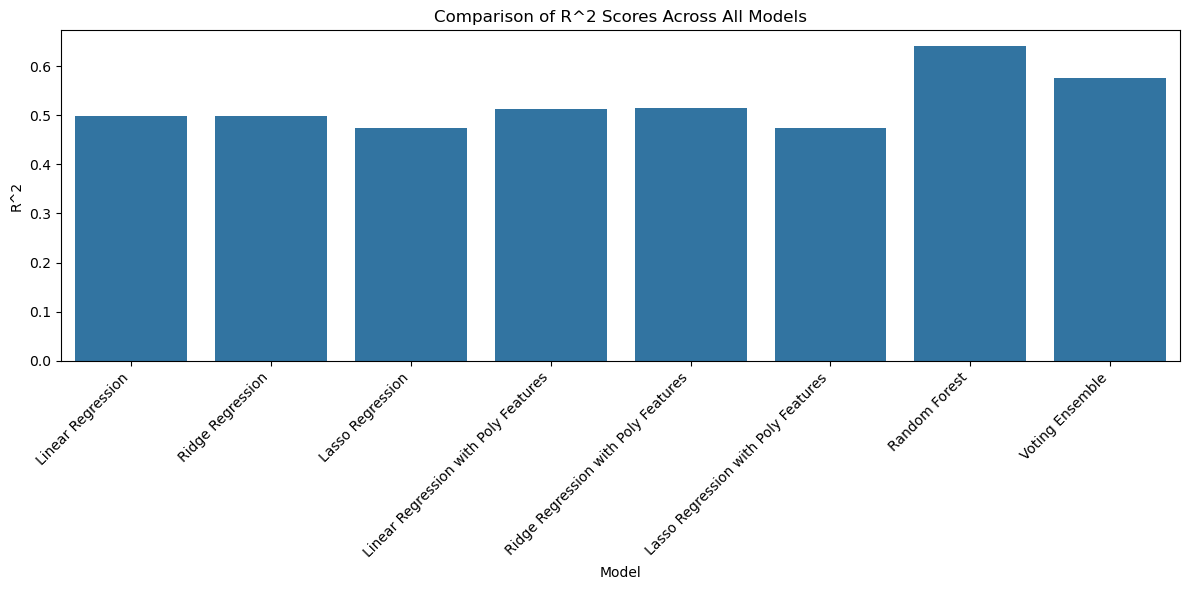

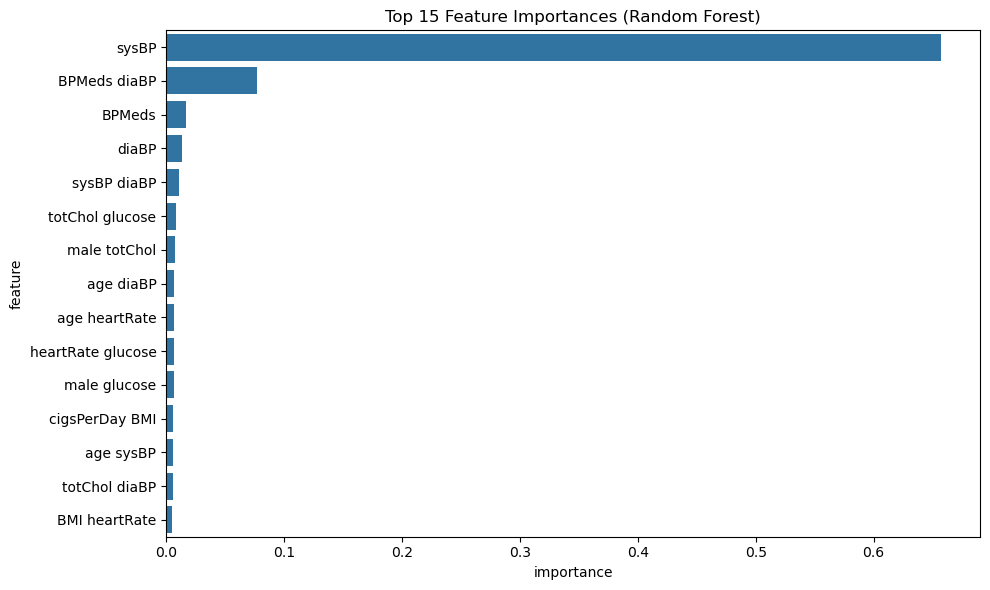


The best model overall is: Random Forest with R^2 score of 0.6408


In [9]:
# Visualize results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R^2', data=all_results)
plt.title('Comparison of R^2 Scores Across All Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Feature importance for Random Forest
# Use get_feature_names_out instead of get_feature_names
feature_names = poly.get_feature_names_out(X.columns)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_grid.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Determine the best model including new ensemble methods
best_model = all_results.loc[all_results['R^2'].idxmax(), 'Model']
best_r2 = all_results['R^2'].max()
print(f"\nThe best model overall is: {best_model} with R^2 score of {best_r2:.4f}")